# 任务三
## 伊拉克地区未来一年受到攻击次数的预测

**Author:** solid

**Date:** sep 18, 2018

### Notebook Configuration 

In [1]:
import time
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### 加载数据集
Load the dataset created by the EDA notebook.

In [5]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_csv('gtd_eda_98t017.csv', low_memory=False, index_col = 0,
                      na_values=[''])

### 丢掉文本属性
Remove the text attributes, which will not be used in the models.

In [8]:
gtd_df = gtd_df.drop(['provstate', 'city', 'summary', 'corp1', 'target1',
                                  'scite1', 'dbsource'], axis=1)

gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113247 entries, 199801010001 to 201712310032
Data columns (total 41 columns):
iyear               113247 non-null int64
imonth              113247 non-null int64
iday                113247 non-null int64
country_txt         113247 non-null category
region_txt          113247 non-null category
latitude            113247 non-null float64
longitude           113247 non-null float64
specificity         113247 non-null category
attacktype1_txt     113247 non-null category
targtype1_txt       113247 non-null category
targsubtype1_txt    113247 non-null category
natlty1_txt         113247 non-null category
gname               113247 non-null object
nperpcap            113247 non-null float64
weaptype1_txt       113247 non-null category
weapsubtype1_txt    113247 non-null category
nkill               113247 non-null float64
nkillus             113247 non-null float64
nkillter            113247 non-null float64
nwound              113247 non-nul

### 归一化数值属性
Adjust for differences in the range of the numeric attributes.

In [9]:
scaler = preprocessing.StandardScaler()

# List of numeric attributes
scale_attrs = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

# Normalize the attributes in place
gtd_df[scale_attrs] = scaler.fit_transform(gtd_df[scale_attrs])

# View the transformation
gtd_df[scale_attrs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nperpcap,113247.0,-3.381326e-15,1.000004,-0.057245,-0.057245,-0.057245,-0.057245,200.937370
nkill,113247.0,2.076507e-15,1.000004,-0.204795,-0.204795,-0.122288,-0.039780,129.331868
nkillus,113247.0,-1.416569e-14,1.000004,-0.006467,-0.006467,-0.006467,-0.006467,239.357505
nkillter,113247.0,-5.579918e-14,1.000004,-0.118464,-0.118464,-0.118464,-0.118464,119.433450
nwound,113247.0,-5.713377e-15,1.000004,-0.090242,-0.090242,-0.090242,-0.013606,209.151966
nwoundus,113247.0,-1.266304e-14,1.000004,-0.021193,-0.021193,-0.021193,-0.021193,205.305847
nwoundte,113247.0,-6.294672e-14,1.000004,-0.070608,-0.070608,-0.070608,-0.070608,135.536943


### Attacks by Year
Plot the number of terrorist incidents by year.

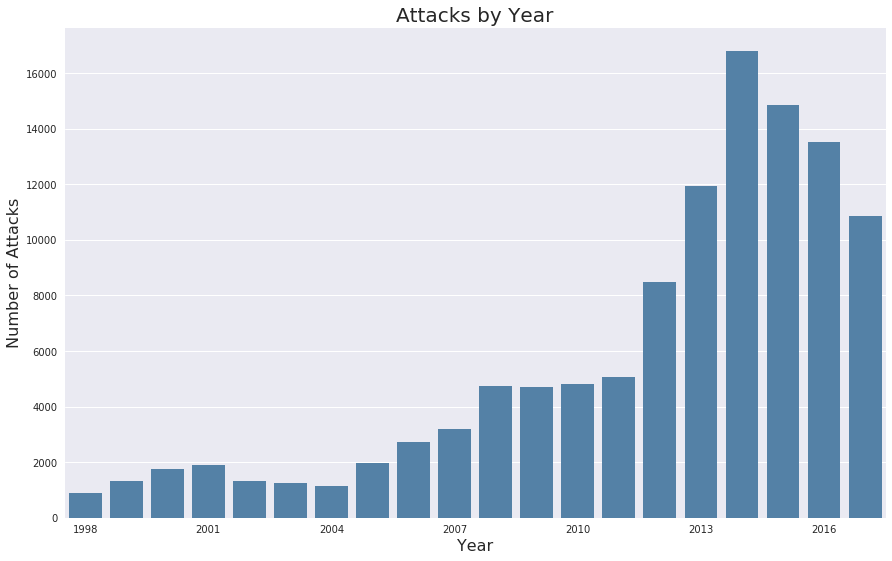

In [51]:
# Make a range of years to show categories with no observations
years = np.arange(1995, 2019)

# Draw a count plot to show the number of attacks each year
plt1 = sns.factorplot("iyear", data=gtd_df, kind="count", color='steelblue', size=7.6, aspect=1.618)
plt1.set_xticklabels(step=3)
_ = plt.title('Attacks by Year', fontsize = 20)
_ = plt.xlabel('Year', fontsize = 16)
_ = plt.ylabel('Number of Attacks', fontsize = 16)
plt.show();

### Fatalities by Year
Plot the number of confirmed fatalities by year.

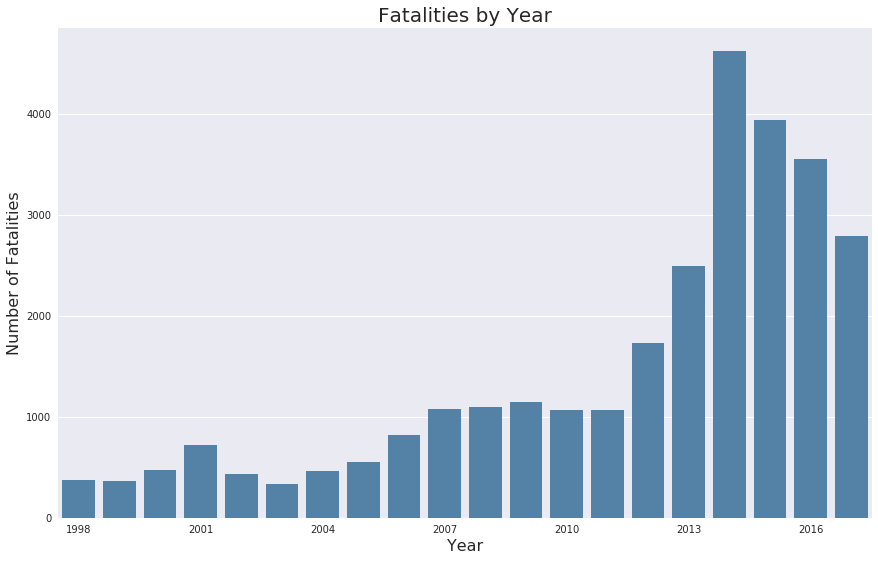

In [61]:
# Make a range of years to show categories with no observations
years = np.arange(1995, 2017)

df1 = gtd_df[['iyear', 'nkill']]
df1['nkill']=abs(df1['nkill'])
gp1 = df1.groupby(['iyear'], as_index = False).sum()

# Draw a count plot to show the number of attacks each year
plt1 = sns.factorplot(x = 'iyear', y = 'nkill', data=gp1, kind = 'bar', color='steelblue', size=7.6, aspect=1.618)
plt1.set_xticklabels(step=3)
_ = plt.title('Fatalities by Year', fontsize = 20)
_ = plt.xlabel('Year', fontsize = 16)
_ = plt.ylabel('Number of Fatalities', fontsize = 16)
plt.show();

### Attack Locations
Plot a sample of attack locations.  The sample is limited to 3,000 lat/long points due to rendering issues between the Folium package and Jupyter notebooks.

In [66]:
import folium

# Get a basic world map.
gtd_map = folium.Map(location=[30, 0], zoom_start=2);

# Take a sample of the data points
gtd_sample = gtd_df.sample(3000);

# Draw markers on the map.
for index, row in gtd_sample.iterrows():
    folium.CircleMarker([row[5], row[6]], radius=0.5, color='#E74C3C', 
                        fill_color='#E74C3C').add_to(gtd_map);


# Show the map
gtd_map

![title](../img/global-map.png)

### 伊拉克
Subset the data to the last 3 year of events in Iraq.

In [28]:
iraq_df = gtd_df[gtd_df['country_txt'] == "Iraq"].query('2014<iyear<=2017')

iraq_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8560 entries, 201412030034 to 201712310012
Data columns (total 41 columns):
iyear               8560 non-null int64
imonth              8560 non-null int64
iday                8560 non-null int64
country_txt         8560 non-null category
region_txt          8560 non-null category
latitude            8560 non-null float64
longitude           8560 non-null float64
specificity         8560 non-null category
attacktype1_txt     8560 non-null category
targtype1_txt       8560 non-null category
targsubtype1_txt    8560 non-null category
natlty1_txt         8560 non-null category
gname               8560 non-null object
nperpcap            8560 non-null float64
weaptype1_txt       8560 non-null category
weapsubtype1_txt    8560 non-null category
nkill               8560 non-null float64
nkillus             8560 non-null float64
nkillter            8560 non-null float64
nwound              8560 non-null float64
nwoundus            8560 non-nul

### 每天受到攻击数量
Calculate the number of attacks per day.

In [29]:
# Group by incident_date
iraq_counts = iraq_df.groupby(['incident_date'], as_index = False).count()

# Select incident_date and a column for the counts
iraq_counts = iraq_counts[['incident_date', 'iyear']]
iraq_counts.columns = ['incident_date','daily_attacks']
iraq_counts.head()

,incident_date,daily_attacks
0,2015-01-01,8
1,2015-01-02,5
2,2015-01-03,10
3,2015-01-04,11
4,2015-01-05,10


### 重新建立索引范围，并填充0到缺失的索引处
Reindex the dataframe to include all days for the 10 year period and fill added days with zero.

In [30]:
idx = pd.date_range('2015-01-01', '2017-12-31')

iraq_ts = iraq_counts.set_index('incident_date')

iraq_ts = iraq_ts.reindex(idx, fill_value=0)
iraq_ts.head()

,daily_attacks
2015-01-01,8
2015-01-02,5
2015-01-03,10
2015-01-04,11
2015-01-05,10


### Summary Statistics
Display summary statistics on the time series dataframe.

In [31]:
iraq_ts.describe()

,daily_attacks
count,1096.000000
mean,7.810219
std,6.279089
min,0.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,108.000000


### Daily Plot - Total Attacks

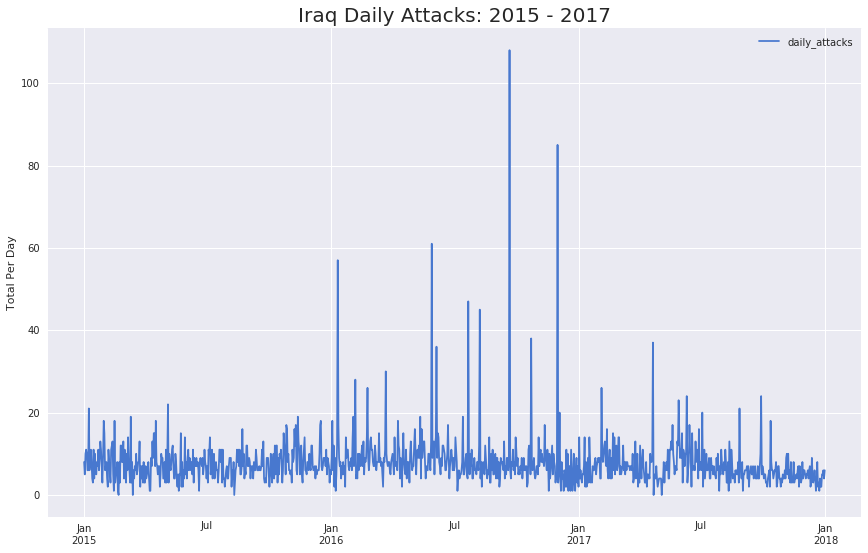

In [32]:
iraq_ts.plot()
plt.title('Iraq Daily Attacks: 2015 - 2017', fontsize=20);
plt.ylabel('Total Per Day')
plt.show();

### Weekly Plot - Average Attacks
Weekly average using the resampled daily data.

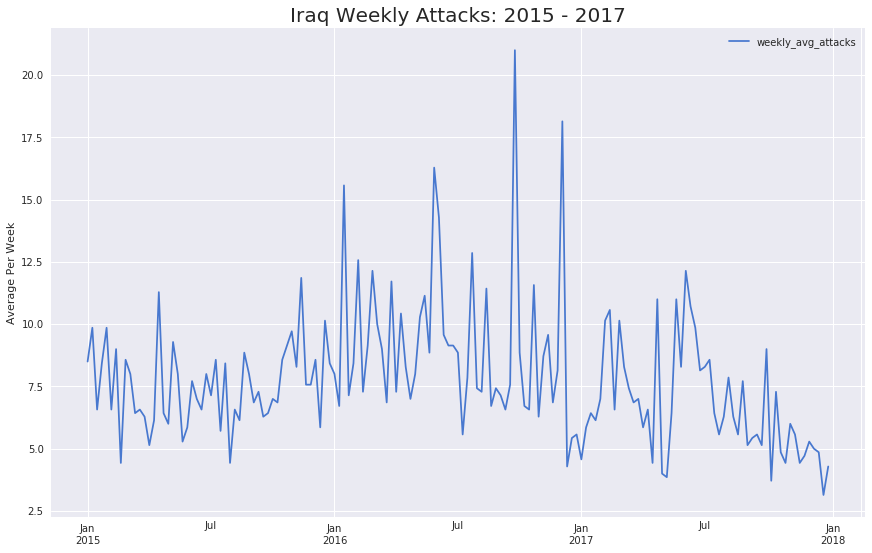

In [33]:
weekly_summary = pd.DataFrame()
weekly_summary['weekly_avg_attacks'] = iraq_ts.daily_attacks.resample('W').mean()

weekly_summary.plot()
plt.title('Iraq Weekly Attacks: 2015 - 2017', fontsize=20);
plt.ylabel('Average Per Week')
plt.show()

### Monthly Plot - Average Attacks
Monthly average using the resampled daily data.

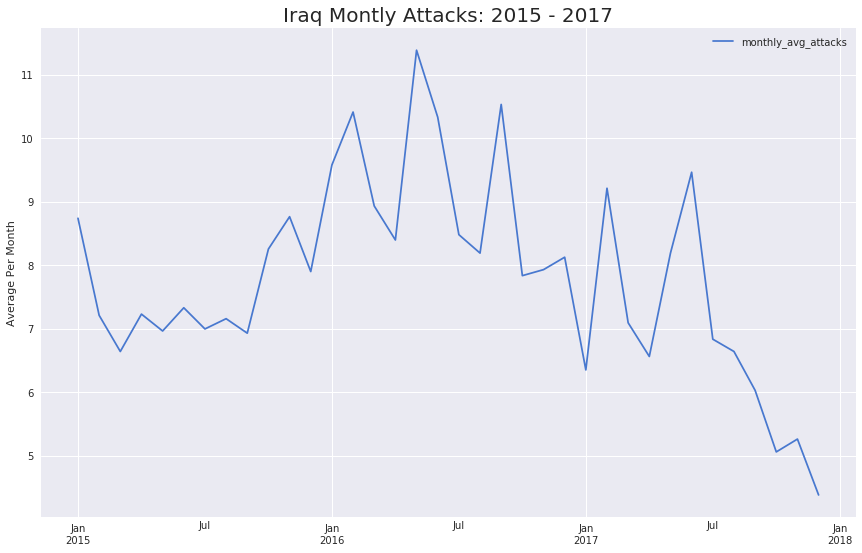

In [34]:
monthly_summary = pd.DataFrame()
monthly_summary['monthly_avg_attacks'] = iraq_ts.daily_attacks.resample('M').mean()

monthly_summary.plot()
plt.title('Iraq Montly Attacks: 2015 - 2017', fontsize=20);
plt.ylabel('Average Per Month')
plt.show();

### Exponential Weighted Moving Average
Apply smoothing using exponential weighted moving average.

In [35]:
# Use a 30 day span for averaging
iraq_ewm = iraq_ts.ewm(span=30, adjust=False).mean()

iraq_ewm.head()

,daily_attacks
2015-01-01,8.000000
2015-01-02,7.806452
2015-01-03,7.947971
2015-01-04,8.144876
2015-01-05,8.264561


### Exponential Weighted Moving Average
Daily attacks in Iraq, 2007 to 2016.

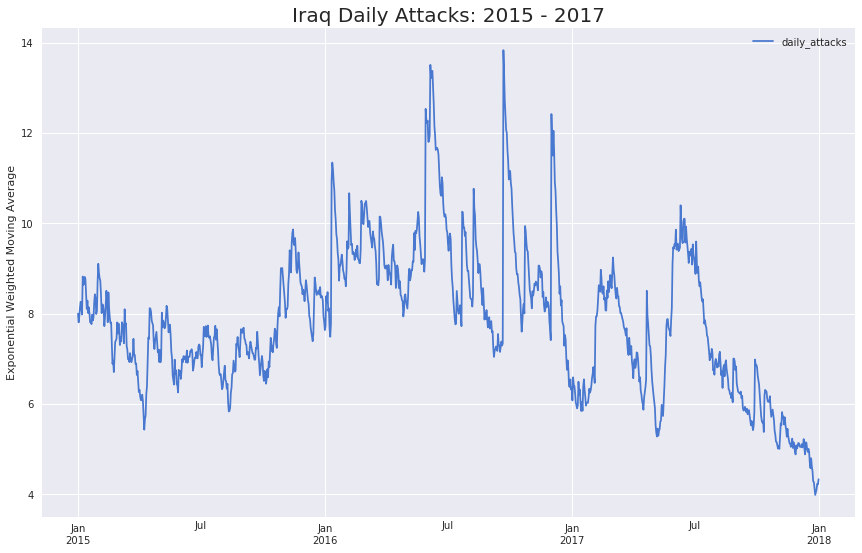

In [36]:
iraq_ewm.plot()
plt.title('Iraq Daily Attacks: 2015 - 2017', fontsize=20);
plt.ylabel('Exponential Weighted Moving Average')
plt.show();

### Facebook Prophet(facebook 开源的一个时序预测模型）
Create a modified dataset to comply with the Facebook Prophet requirements.

In [37]:
import fbprophet

iraq_fb = iraq_ts.copy()
iraq_fb['index1'] = iraq_fb.index
iraq_fb.columns = ['y', 'ds']

iraq_fb.head()

,y,ds
2015-01-01,8,2015-01-01
2015-01-02,5,2015-01-02
2015-01-03,10,2015-01-03
2015-01-04,11,2015-01-04
2015-01-05,10,2015-01-05


### 伊拉克节假日
Iraq regional and national holidays covering 2015 - 2017.

In [42]:
# Load the preprocessed GTD dataset
iraq_holidays = pd.read_csv('Iraq-holiday.csv', na_values=[''])
iraq_holidays.head()

,ds,holiday
0,2015-01-01,New Years Day
1,2015-01-02,Mawlid alNabi
2,2015-01-06,Army Day
3,2015-03-21,Eid Norooz
4,2015-05-01,Labour Day


### 时序模型
Create the time serie model for attacks in Iraq and factor in Iraq holidays.

In [43]:
# Make the prophet model and fit on the data
prophet1 = fbprophet.Prophet(changepoint_prior_scale=0.15, holidays=iraq_holidays)
prophet1.fit(iraq_fb)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 预测伊拉克未来一年收到攻击次数的数据
Predict 365 days after last the data point of 2017-12-31.

In [44]:
# Specify 365 days out to predict
future_data = prophet1.make_future_dataframe(periods=365, freq = 'D')

# Predict the values
forecast_data = prophet1.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#forecast_data.tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2018-12-27,0.132753,-7.643409,7.757215
1457,2018-12-28,-1.387899,-9.450241,5.997623
1458,2018-12-29,0.040187,-7.899139,7.886457
1459,2018-12-30,0.926348,-6.703206,8.710022
1460,2018-12-31,0.395935,-7.690386,7.762739


### 预测图（浅蓝色部分代表上边界和下边界）

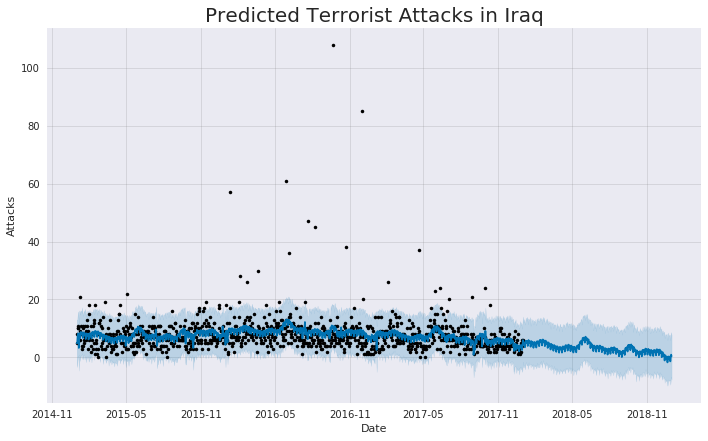

In [45]:
prophet1.plot(forecast_data, xlabel = 'Date', ylabel = 'Attacks')
plt.title('Predicted Terrorist Attacks in Iraq', fontsize=20);
plt.show();

### 分析图像合理性以及各个成分图
6月的飙升发生在Eid ul-Fitr或Id-Ul-Fitr（斋月结束）之前，12月的跳跃发生在Mouloud（先知的诞生）之后。 9月份的下降发生在Eid al-Adha（牺牲盛宴）和伊斯兰新年附近。 周五发生的攻击次数较少，与穆斯林星期五祈祷相对应。

由于Prophet使用加性模型，y轴代表相对于趋势的绝对变化（Letham，2018）

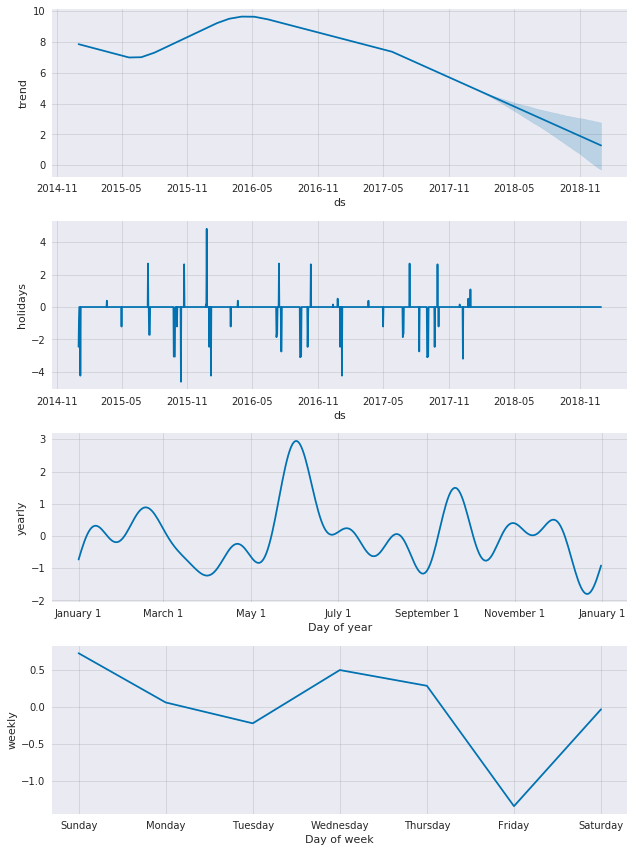

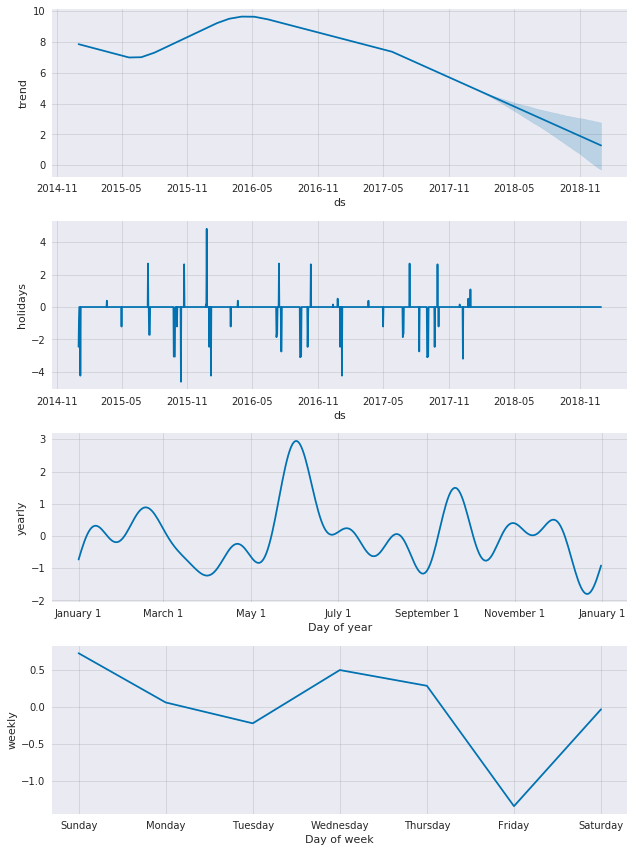

In [49]:
prophet1.plot_components(forecast_data)

### Zoom in to the Last Year Plus One Year of Predictions
The forecasted trend seems to align with the yearly seasonality shown in the component analysis.

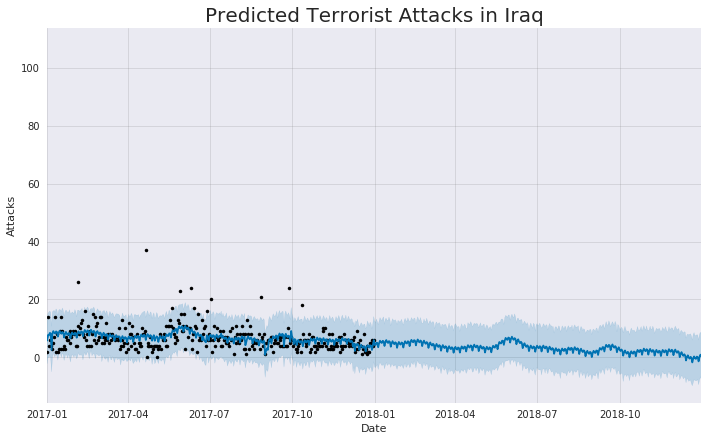

In [48]:
prophet1.plot(forecast_data, xlabel = 'Date', ylabel = 'Attacks')
plt.title('Predicted Terrorist Attacks in Iraq', fontsize=20);
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2018-12-31'))
plt.show();

### References

Brown, E. (2017). Forecasting time-series data with Prophet – Part 1. Retrieved from http://pythondata.com/forecasting-time-series-data-with-prophet-part-1/

Facebook Open Source. (n.d.). Seasonality and holiday effects. Retrieved from http://holidayyear.com/holidays/Iraq/

Holidayyear. (2018). Iraqi public holidays. Retrieved from http://holidayyear.com/holidays/Iraq/

Letham, B. (2018). Meaning of y-axis in component plot. Retrieved from https://github.com/facebook/prophet/issues/422

Wikipedia. (2018). Sabbath. Retrieved from https://en.wikipedia.org/wiki/Sabbath